<h1>Cart Pole RL Algoriths:</h1>

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque


In [2]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [3]:
# Define the number of bins for each dimension of the state space (to discretisize the state)
num_bins = np.array([30, 30, 30, 30])

# Define the range for each dimension based on the observation space
state_min = env.observation_space.low
state_max = env.observation_space.high
state_range = state_max - state_min

# Calculate the total number of discrete states
num_states = np.prod(num_bins)

# Define the number of actions
num_actions = env.action_space.n

/tmp/ipykernel_33/1238775683.py:7: RuntimeWarning: overflow encountered in subtract
  state_range = state_max - state_min


In [4]:
! pip install pygame
! apt-get install xvfb
! pip install gym pyvirtualdisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 82.4 MB/s eta 0:00:00:00:01:01
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.17).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


In [5]:
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation

d = Display()
d.start()

In [6]:
# returns a 4-dimensional tuple defining the indices
# that correspond to "state" input
#The velocity and angular velocity ranges are extremely large (from -inf to inf).
# To manage this, the function shrinks these ranges by dividing by a large number (1e38).
# This helps to avoid the 'inf' effect and ensures that the state space is finite and manageable.

def return_index_state(state):
    
        cartPositionBin=np.linspace(state_min[0],state_max[0],num_bins[0])
        # shrink the range of the cart velocity instead of the initial range (-inf, inf)
        cartVelocityBin=np.linspace(state_min[1]/1e38,state_max[1]/1e38,num_bins[1])
        poleAngleBin=np.linspace(state_min[2],state_max[2],num_bins[2])
        # shrink the range of the pole angle velocity instead of the initial range (-inf, inf)
        poleAngleVelocityBin=np.linspace((state_min[3]/1e38),(state_max[3]/1e38),num_bins[3])

        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)

        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])

<h2>Monte Carlo</h2>

In [7]:
# Initialize q_table table
q_table = np.zeros((num_bins[0], num_bins[1], num_bins[2], num_bins[3], num_actions))

# Initialize policy
policy = {}

# Initialize returns dictionary
returns_sum = {}
returns_count = {}

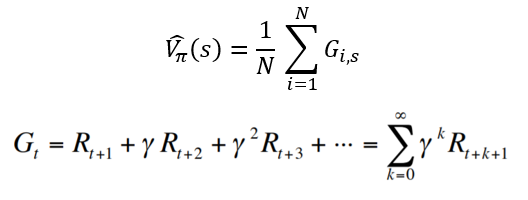

In [8]:
num_episodes = 15000
max_steps_per_episode = 500
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 0.2
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005
discount_factor = 0.99

rewards_all_episodes = []
# Deque for keeping track of rewards
rewards_last_100_episodes = deque(maxlen=100)
np.random.seed(42)

In [9]:
for episode in range(num_episodes):
    state = env.reset()[0]
    done = False
    rewards_cur_episode = 0
    discretized_state = return_index_state(state)
    
    # Choose action using epsilon-greedy policy
    exploration_threshold = np.random.uniform(0, 1)
    if exploration_threshold > exploration_rate:
        action = np.random.choice(np.where(q_table[discretized_state] == np.max(q_table[discretized_state]))[0])
    else:
        action = env.action_space.sample()
    
    # Generate an episode
    episode_data = []
    while not done:
        next_state, reward, done, *_ = env.step(action)
        episode_data.append((state, action, reward))
        discretized_next_state = return_index_state(next_state)
        
        # Choose next action using epsilon-greedy policy
        exploration_threshold = np.random.uniform(0, 1)
        if exploration_threshold > exploration_rate:
            next_action = np.random.choice(np.where(q_table[discretized_next_state] == np.max(q_table[discretized_next_state]))[0])
        else:
            next_action = env.action_space.sample()
        
        state = next_state
        action = next_action
        rewards_cur_episode += reward
        
        if done:
            break
    
    G = 0
    visited_state_action_pairs = set()
    for t in range(len(episode_data) - 1, -1, -1):
        state, action, reward = episode_data[t]
        discretized_state = return_index_state(state)
        state_action_pair = (discretized_state, action)  # Use discretized state
        G = discount_factor * G + reward

        if state_action_pair not in visited_state_action_pairs:
            visited_state_action_pairs.add(state_action_pair)
            if state_action_pair not in returns_sum:
                returns_sum[state_action_pair] = 0
                returns_count[state_action_pair] = 0

            returns_sum[state_action_pair] += G
            returns_count[state_action_pair] += 1
            q_table[state_action_pair[0] + (action,)] = returns_sum[state_action_pair] / returns_count[state_action_pair]  # Use compatible index
            best_action = np.argmax(q_table[state_action_pair[0]])  # Use compatible index
            policy[state_action_pair[0]] = best_action  # Use compatible index
    
    # Update exploration rate
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(
        -exploration_decay_rate * episode)
    
    # Append rewards for current episode
    rewards_last_100_episodes.append(rewards_cur_episode)
    rewards_all_episodes.append(rewards_cur_episode)
    
    # Calculate the average reward of the last 100 episodes
    average_reward = np.mean(rewards_last_100_episodes)
    
    # Print the average reward every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"***Episode {episode + 1}: Average Reward of last 100 episodes: {average_reward}***")
    
    # Check if the average reward is greater than or equal to 190
    if average_reward >= 200:
        print(f"********Average reward of {average_reward} achieved at episode {episode + 1}********")
        break

print("*******Training Finished*******")


/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


***Episode 100: Average Reward of last 100 episodes: 31.89***
***Episode 200: Average Reward of last 100 episodes: 53.12***
***Episode 300: Average Reward of last 100 episodes: 88.36***
***Episode 400: Average Reward of last 100 episodes: 116.4***
***Episode 500: Average Reward of last 100 episodes: 141.41***
***Episode 600: Average Reward of last 100 episodes: 180.12***
********Average reward of 201.07 achieved at episode 658********
*******Training Finished*******


In [10]:
np.mean(rewards_last_100_episodes)

201.07

<h3>Evaluating Monte Carlo Model</h3>

Episode:  99
******Failed******


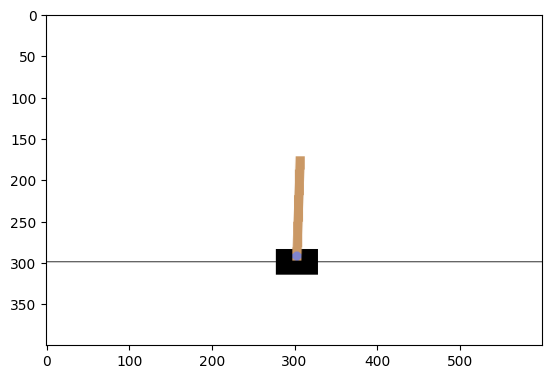

In [11]:
for episode in range(100):
  state = env.reset()[0]
  done = False
  display.clear_output(wait=True)
  print("Episode: ", episode)

  prev_screen = env.render()
  plt.imshow(prev_screen)
  img = []
  cur_total_reward = 0
  for step in range(max_steps_per_episode):
    discretized_state = return_index_state(state)
    action = np.random.choice(np.where(q_table[discretized_state]==np.max(q_table[discretized_state]))[0])

    next_state, reward, done, *_ = env.step(action)
    cur_total_reward += reward

    #display.clear_output(wait=True)
    img.append(env.render())

    #print("step: ", step, " reward: ", reward)


    if done:
      #display.clear_output(wait=True)
      if cur_total_reward >= 195:
        print("******Reached Goal******")
      else:
        print("******Failed******")
      img.append(env.render())

      break
    state = next_state

env.close()

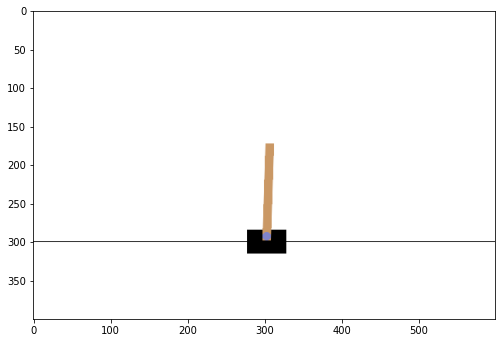

In [12]:
dpi = 72
interval = 50 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

<h2>Q-Learning</h2>

In [13]:
# Initialize the Q-Learning q-table with zeros
q_table = np.zeros((num_bins[0], num_bins[1], num_bins[2], num_bins[3], num_actions))

<h3>Parameters of the Q-Learning Algorithm:</h3>

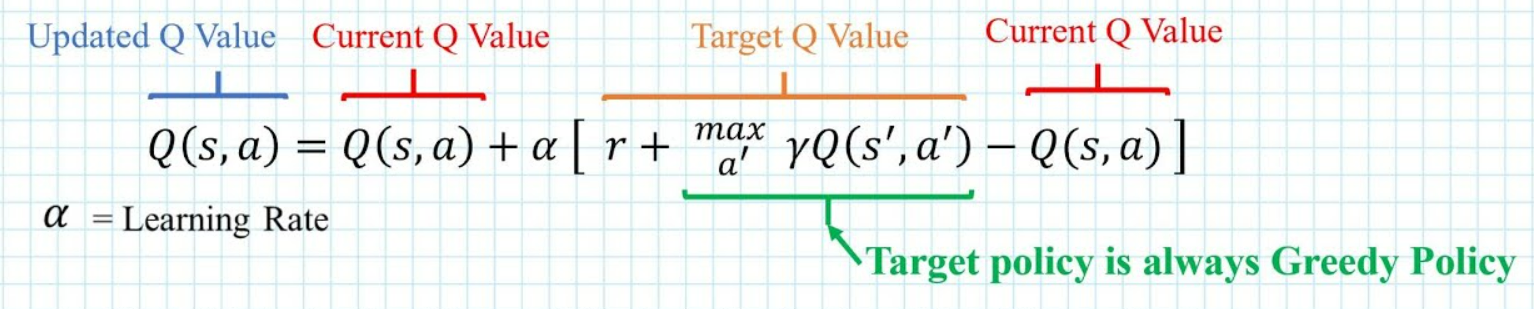

In [14]:
num_episodes = 15000
max_steps_per_episode = 500
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 0.2
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

rewards_all_episodes = []
# Deque for keeping track of rewards
rewards_last_100_episodes = deque(maxlen=100)
np.random.seed(42)

In [ ]:
for episode in range(num_episodes):
    state = list(env.reset())
    #env.render()
    done = False
    rewards_cur_episode = 0
    discretized_state = return_index_state(state[0])

    for step in range(max_steps_per_episode):
        # Exploration vs Exploitation trade-off
        exploration_threshold = np.random.uniform(0, 1)
        if exploration_threshold > exploration_rate:
            # np.where(a==np.max(a))
            # this will return [1,2], but we only need a single index
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # a=[0,1,1,0]
            action = np.random.choice(np.where(q_table[discretized_state]==np.max(q_table[discretized_state]))[0])
        else:
            action = env.action_space.sample()

        next_state, reward, done, *_ = env.step(action)

        # Discretize the next state
        discretized_next_state = return_index_state(next_state)

        # Update Q-table
        q_table[discretized_state + (action,)] = q_table[discretized_state + (action,)] + learning_rate * (reward + discount_rate * np.max(q_table[discretized_next_state]) - q_table[discretized_state + (action,)])

        # Update current state and rewards
        state = next_state
        discretized_state = discretized_next_state
        rewards_cur_episode += reward

        if done:
            break

    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

    # Append rewards for current episode
    rewards_last_100_episodes.append(rewards_cur_episode)
    rewards_all_episodes.append(rewards_cur_episode)

    # Calculate the average reward of the last 100 episodes
    average_reward = np.mean(rewards_last_100_episodes)

    #Print the average reward every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"***Episode {episode + 1}: Average Reward of last 100 episodes: {average_reward}***")
    #print(f"Reward of Episode {episode + 1}: {rewards_cur_episode}")

    # Check if the average reward is greater than or equal to 190
    if average_reward >= 200:
        print(f"********Average reward of {average_reward} achieved at episode {episode + 1}********")
        break

print("*******Training Finished*******")


***Episode 100: Average Reward of last 100 episodes: 25.64***
***Episode 200: Average Reward of last 100 episodes: 38.42***
***Episode 300: Average Reward of last 100 episodes: 55.16***
***Episode 400: Average Reward of last 100 episodes: 70.05***
***Episode 500: Average Reward of last 100 episodes: 68.04***
***Episode 600: Average Reward of last 100 episodes: 78.21***
***Episode 700: Average Reward of last 100 episodes: 83.78***
***Episode 800: Average Reward of last 100 episodes: 79.27***
***Episode 900: Average Reward of last 100 episodes: 80.89***
***Episode 1000: Average Reward of last 100 episodes: 73.82***
***Episode 1100: Average Reward of last 100 episodes: 56.3***
***Episode 1200: Average Reward of last 100 episodes: 60.1***
***Episode 1300: Average Reward of last 100 episodes: 59.07***
***Episode 1400: Average Reward of last 100 episodes: 53.99***
***Episode 1500: Average Reward of last 100 episodes: 53.57***
***Episode 1600: Average Reward of last 100 episodes: 53.34***
***

In [ ]:
np.mean(rewards_last_100_episodes)

<h3>Evaluating the Model:</h3>

In [ ]:
for episode in range(100):
  state = env.reset()[0]
  done = False
  display.clear_output(wait=True)
  print("Episode: ", episode)

  prev_screen = env.render()
  plt.imshow(prev_screen)
  img = []
  cur_total_reward = 0
  for step in range(max_steps_per_episode):
    discretized_state = return_index_state(state)
    action = np.random.choice(np.where(q_table[discretized_state]==np.max(q_table[discretized_state]))[0])

    next_state, reward, done, *_ = env.step(action)
    cur_total_reward += reward

    #display.clear_output(wait=True)
    img.append(env.render())

    #print("step: ", step, " reward: ", reward)


    if done:
      #display.clear_output(wait=True)
      if cur_total_reward >= 195:
        print("******Reached Goal******")
      else:
        print("******Failed******")
      img.append(env.render())

      break
    state = next_state

env.close()

In [ ]:
dpi = 72
interval = 50 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

<h2>Sarsa</h2>

<h3>Parameters of the Sarsa Algorithm:</h3>

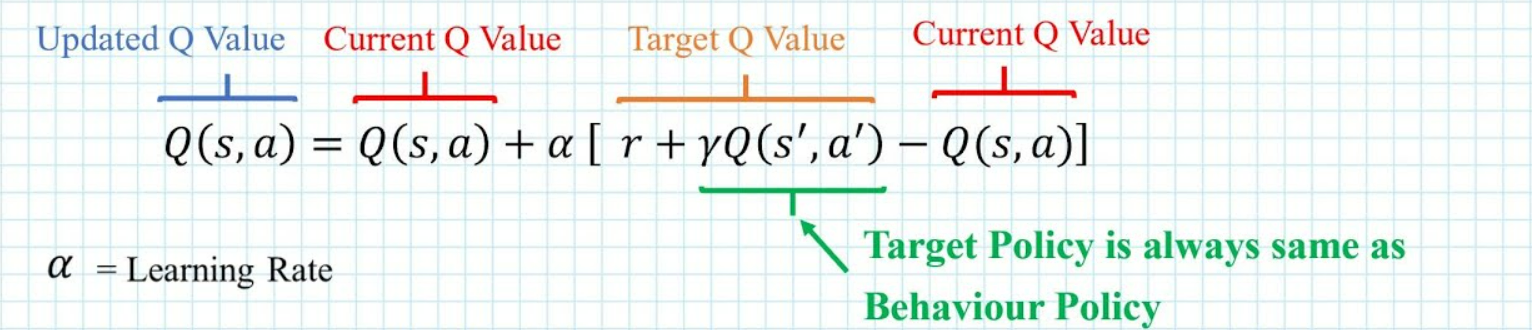

In [ ]:
import numpy as np
# Initialize the Q-table with zeros
q_table = np.zeros((num_bins[0], num_bins[1], num_bins[2], num_bins[3], num_actions))

from collections import deque

num_episodes = 15000
max_steps_per_episode = 500
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 0.2
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

rewards_all_episodes = []
# Deque for keeping track of rewards
rewards_last_100_episodes = deque(maxlen=100)
np.random.seed(42)

In [ ]:
for episode in range(num_episodes):
    state = list(env.reset())
    # env.render()
    done = False
    rewards_cur_episode = 0
    discretized_state = return_index_state(state[0])
    
    # Choose action using epsilon-greedy policy
    exploration_threshold = np.random.uniform(0, 1)
    if exploration_threshold > exploration_rate:
        action = np.random.choice(np.where(q_table[discretized_state] == np.max(q_table[discretized_state]))[0])
    else:
        action = env.action_space.sample()
    
    for step in range(max_steps_per_episode):
        next_state, reward, done, *_ = env.step(action)
        discretized_next_state = return_index_state(next_state)
        
        # Choose next action using epsilon-greedy policy
        exploration_threshold = np.random.uniform(0, 1)
        if exploration_threshold > exploration_rate:
            next_action = np.random.choice(np.where(q_table[discretized_next_state] == np.max(q_table[discretized_next_state]))[0])
        else:
            next_action = env.action_space.sample()
        
        # Update Q-table using SARSA update rule
        q_table[discretized_state + (action,)] = q_table[discretized_state + (action,)] + learning_rate * (
                    reward + discount_rate * q_table[discretized_next_state + (next_action,)] - q_table[
                discretized_state + (action,)])
        
        # Update current state, action, and rewards
        state = next_state
        discretized_state = discretized_next_state
        action = next_action
        rewards_cur_episode += reward
        
        if done:
            break
    
    # Update exploration rate
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(
        -exploration_decay_rate * episode)
    
    # Append rewards for current episode
    rewards_last_100_episodes.append(rewards_cur_episode)
    rewards_all_episodes.append(rewards_cur_episode)
    
    # Calculate the average reward of the last 100 episodes
    average_reward = np.mean(rewards_last_100_episodes)
    
    # Print the average reward every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"***Episode {episode + 1}: Average Reward of last 100 episodes: {average_reward}***")
    
    # Check if the average reward is greater than or equal to 190
    if average_reward >= 200:
        print(f"********Average reward of {average_reward} achieved at episode {episode + 1}********")
        break

print("*******Training Finished*******")

In [ ]:
np.mean(rewards_last_100_episodes)

<h3>Evaluating the Sarsa Model</h3>

In [ ]:
for episode in range(100):
  state = env.reset()[0]
  done = False
  display.clear_output(wait=True)
  print("Episode: ", episode)

  prev_screen = env.render()
  plt.imshow(prev_screen)
  img = []
  cur_total_reward = 0
  for step in range(max_steps_per_episode):
    discretized_state = return_index_state(state)
    action = np.random.choice(np.where(q_table[discretized_state]==np.max(q_table[discretized_state]))[0])

    next_state, reward, done, *_ = env.step(action)
    cur_total_reward += reward

    #display.clear_output(wait=True)
    img.append(env.render())

    #print("step: ", step, " reward: ", reward)


    if done:
      #display.clear_output(wait=True)
      if cur_total_reward >= 195:
        print("******Reached Goal******")
      else:
        print("******Failed******")
      img.append(env.render())

      break
    state = next_state

env.close()

In [ ]:
dpi = 72
interval = 50 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

# **Monte Carlo**
Average reward of 201.39 achieved at episode 567

Monte Carlo methods, learn from complete episodes—only updating their policy at the end of each episode. This approach is effective in environments where the dynamics are highly stochastic, as it utilizes actual returns for learning rather than relying on estimated values. The quick achievement of a high reward with fewer episodes suggests that the complete episode information was sufficient for effective learning in the relatively simple and controlled environment of CartPole, despite the potential inefficiency in environments where episodes are very long.

# **Q-Learning**
Average reward of 200.47 achieved at episode 12002

Q-Learning, is an off-policy temporal difference learning algorithm that learns the optimal policy independently of the agent's actions by always updating using the maximum estimated future reward. However, it can often overestimate Q-values, potentially leading to a slower convergence in environments with noisy or stochastic transitions, as seen in its relatively slower performance and higher episode count in the CartPole scenario. This might indicate inefficiencies in exploration and the need for more episodes to accurately estimate the Q-values. 

# **Sarsa**
Average reward of 203.16 achieved at episode 4559

SARSA, updates its policy based on the actions actually taken, including exploratory moves, making it an on-policy algorithm. This method tends to learn safer or more conservative policies because it incorporates the actual policy into its updates. The balance achieved by SARSA, between episodes to convergence and reward effectiveness, suggests it managed to efficiently explore and exploit the environment, learning a robust policy that cautiously improves while considering the potential risks of exploratory actions.